In [16]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools as it
# load new data
real_dict = {}
for dimension in [20, 25, 30]:
    s = pd.read_pickle("sim_results/d{}".format(dimension))
    real_dict.update(s)

return_dict = copy.deepcopy(real_dict)
n_vec = [300, 400, 500]
d_vec =[20, 25, 30]
D_vec = [20, 25, 30]
folds = 10
stat_list = ['rmse', 'nll', 'crps', 'cov']
meth_list = ['gpy','vim', 'dle', 'dpa']

meth_vec = ["vim", "vim2", "vim3", "vim4"]

#go through dictionaryries and 
#select method with the lowest loss
for d in d_vec:
    for n in n_vec:
        rel_dict = copy.deepcopy(real_dict[d][n])
        
        meth_list = []
        for l in range(10):
            temp = "woof"
            loss = 100000
            for meth in meth_vec:                
                if rel_dict[l][meth]['loss'].item() < loss:
                    temp = meth
                    loss = rel_dict[l][meth]['loss'].item()
            
            rel_dict[l]['vimb'] = rel_dict[l][temp]
            
            meth_list.append(rel_dict[l])
        
        return_dict[d][n] = meth_list            
            
d_dict = copy.deepcopy(return_dict)       

# load data for R methods
sim_table = pd.read_csv("R_Results/sim_sim.csv")
sim_table = sim_table.rename(columns = {"Dimension": "D", "val": "Value"})
sim_table['Method'] = "SIM-GP"


bart_table = pd.read_csv("R_Results/sim_sim_bart.csv")
bart_table = bart_table.rename(columns = {"Dimension": "D", "val": "Value"})
bart_table['Method'] = "BART"

sim_table = pd.concat([sim_table, bart_table])

stat_replace = {'rmse': 'RMSE', 'crps': "CRPS", 'cov': "95% Coverage", "nll": "NLL"}
sim_table['Statistic'] = sim_table['Statistic'].replace(stat_replace)





# Figure 4

In [19]:


import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 75}

matplotlib.rc('font', **font)


stat_list = ['rmse', 'nll', 'crps', 'cov']
meth_list = ['gpy','vimb', 'dle', 'dpa']
D_vec = [20, 25, 30]
folds = 10
fold_list = [i + 1 for  i in range(folds)]
#sample_list = sample_vec.copy()
sample_list = [300, 400, 500]
combs = it.product(meth_list, sample_list, stat_list, fold_list, D_vec)

start_frame = pd.DataFrame(list(combs), columns = ["Method", "n", "Statistic", "Fold", "D"])



val = np.zeros(start_frame.shape[0])
bad_folds = []
for index, row in start_frame.iterrows():    
    val[index] = d_dict[row[-1]][row[1]][row[3] - 1][row[0]][row[2]].item()
    
g_frame = start_frame.join(pd.DataFrame(val, columns = ["Value"]))
g_frame = pd.concat([g_frame, sim_table])
stat_replace = {'rmse': 'RMSE', 'crps': "CRPS", 'cov': "95% Coverage", "nll": "NLL"}
g_frame['Statistic'] = g_frame['Statistic'].replace(stat_replace)
met_replace = {'gpy': "ARD-GP", 'vimb': 'AdMIn-GP', 'vim2': 'AdMIn-GP 2','dle': 'DR-GP', 'dpa': 'DPA-GP', 
              'vim3': "AdEm-GP 3", 'vim4': 'AdEm-GP 4', "sim":"SIM-GP"}
g_frame['Method'] = g_frame['Method'].replace(met_replace)




first_frame = g_frame[g_frame['Method'].isin(["ARD-GP", "DR-GP", "DPA-GP", "AdMIn-GP", "SIM-GP", "BART"])]
stat_list = ['RMSE', 'CRPS','95% Coverage']

fig, axs = plt.subplots(3, 3, figsize = (160, 80))

#compare 3 mixture to others
for j, d in enumerate(D_vec):
    for i, stat in enumerate(stat_list):
            sns.boxplot(data = first_frame[ np.logical_and(first_frame["Statistic"] == stat_list[i], first_frame['D'] == d) ],
                        y = "Value", x = "n",  hue = "Method", 
                           ax = axs[j, i], dodge= .25, fliersize= 0, linewidth=20, hue_order = ["ARD-GP",  "AdMIn-GP", "DR-GP", "DPA-GP", "SIM-GP", "BART"])

            axs[j, i].set_xlabel("n", fontweight = 'bold', fontsize = 70)
            axs[j, i].set_title("d = {}, {}".format(d, stat_list[i]), fontweight = 'bold')

            if not i in [2,3]:
                axs[j, i].set_yscale("log")
                axs[j, i].set_ylabel("{} Log-Scale".format(stat_list[i]), fontweight = 'bold',fontsize = 70)
            else:
                axs[j,i].set_ylabel(stat_list[i], fontweight = 'bold', fontsize=  70)

            if stat == "95% Coverage":
                axs[j,i].axhline(y = .95, alpha = 1, lw = 5)
                axs[j, i].set_ylim((0, 1))
            if j != 2 or i != 0:
                axs[j, i].get_legend().remove()

axs[2, 0].legend(loc='upper center', bbox_to_anchor=(0.55, -0.2), ncol=3, fancybox=True, shadow=False)

plt.savefig('paper_plots/other_mix.png', dpi = 20)



/tmp/ipykernel_3651758/640573357.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val[index] = d_dict[row[-1]][row[1]][row[3] - 1][row[0]][row[2]].item()


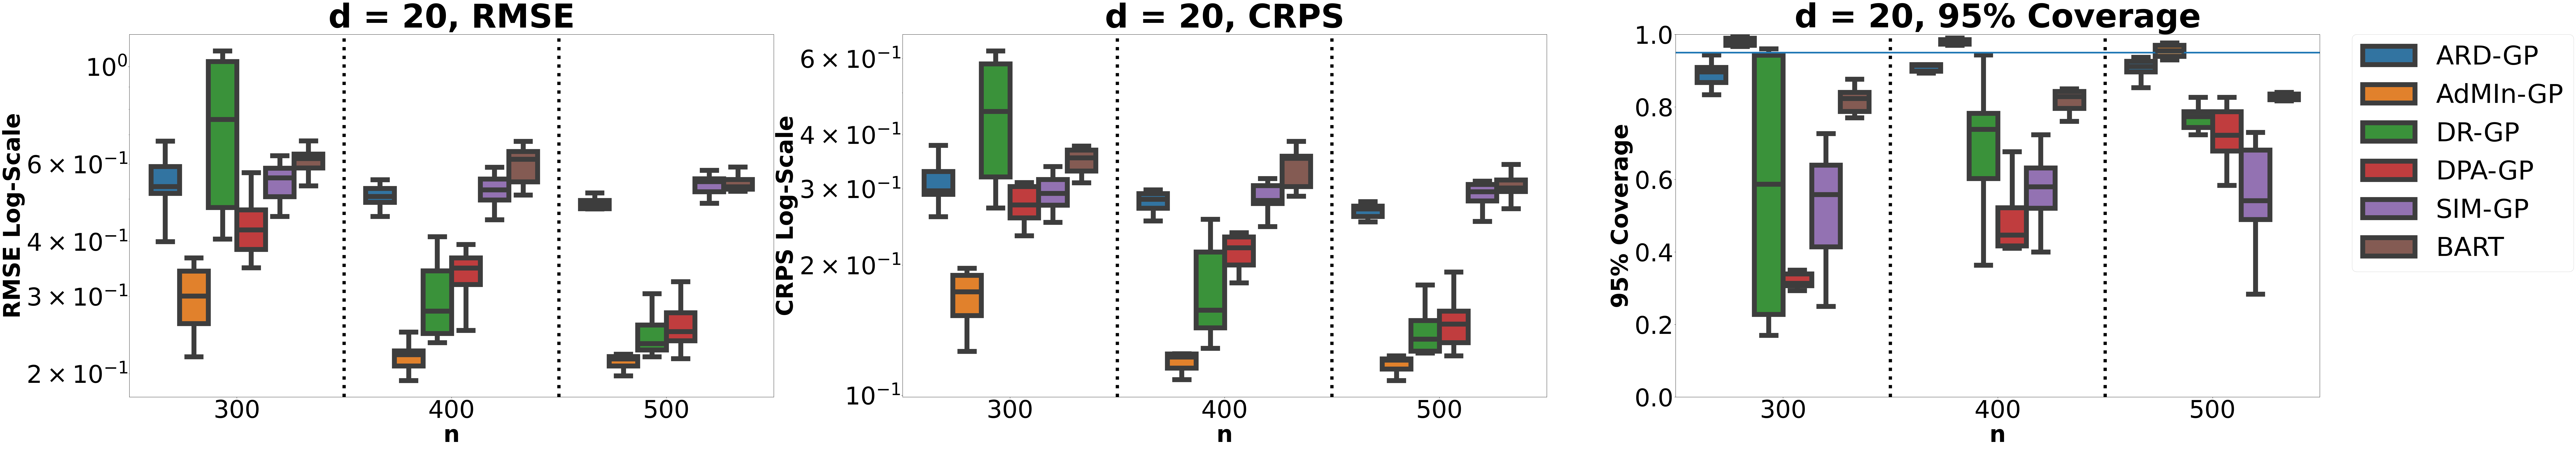

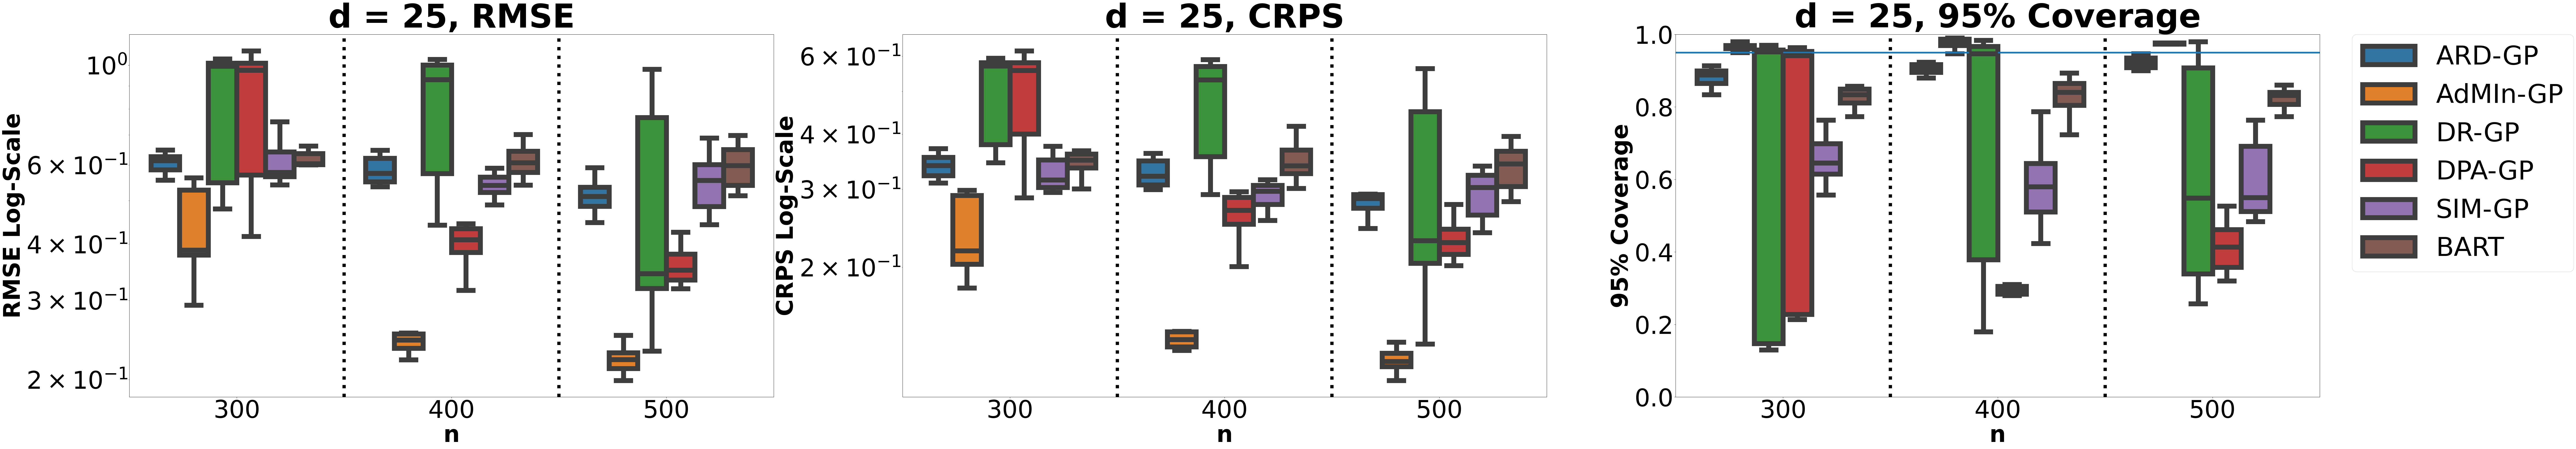

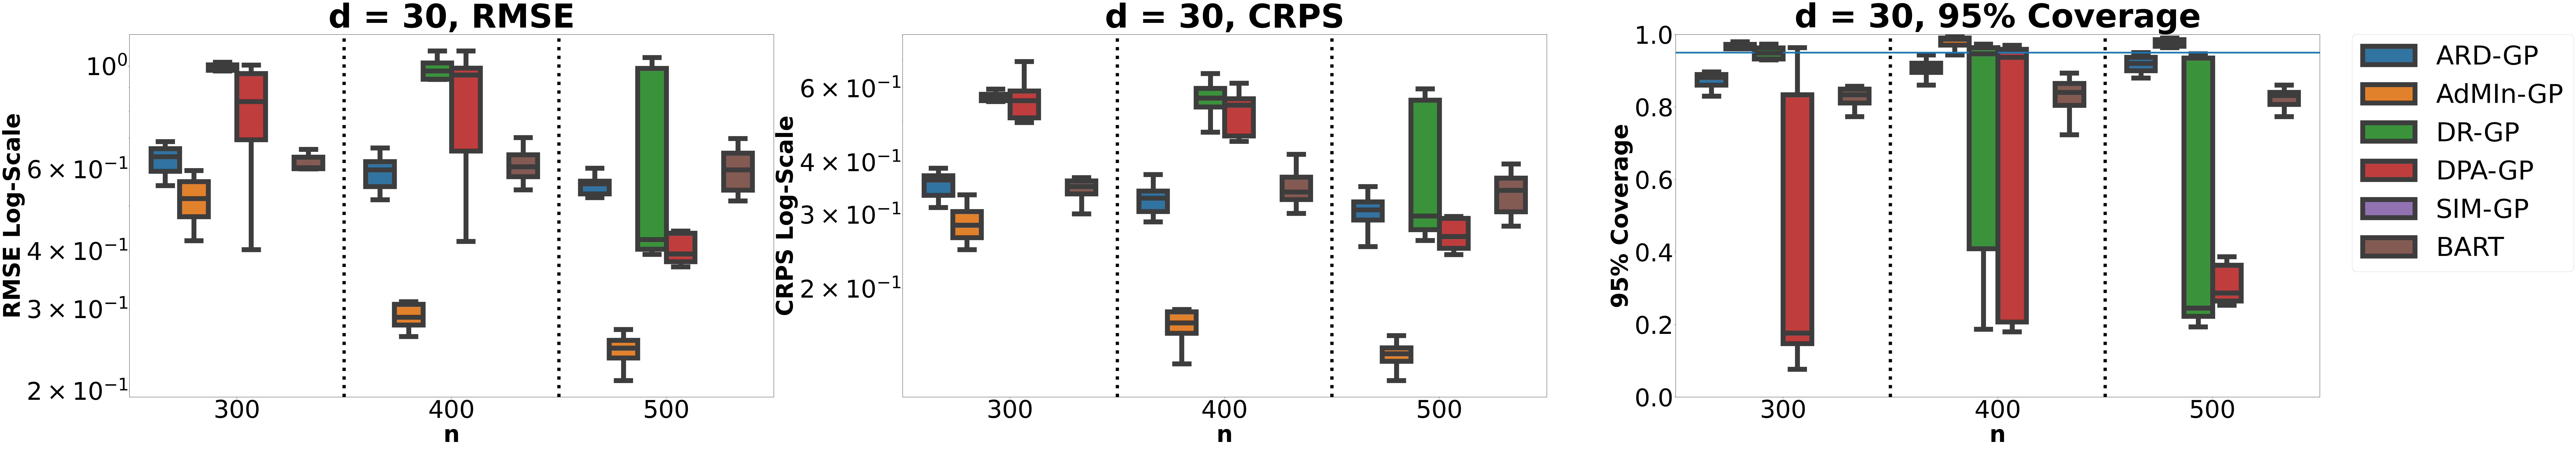

In [18]:

import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 75}

matplotlib.rc('font', **font)

#compare 3 mixture to others
for j, d in enumerate(D_vec):
    fig, axs = plt.subplots(1, 3, figsize = (120, 20))
    for i, stat in enumerate(stat_list):
        sns.boxplot(data = first_frame[ np.logical_and(first_frame["Statistic"] == stat_list[i], first_frame['D'] == d) ],
                    y = "Value", x = "n",  hue = "Method", 
                       ax = axs[i], dodge= .25, fliersize= 0, linewidth=15, hue_order = ["ARD-GP",  "AdMIn-GP", "DR-GP", "DPA-GP", "SIM-GP", "BART"])

        axs[i].set_xlabel("n", fontweight = 'bold', fontsize = 70)
        axs[i].set_title("d = {}, {}".format(d, stat_list[i]), fontweight = 'bold', fontsize = 100)
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize = 80)
        if not i in [2,3]:
            axs[i].set_yscale("log")
            axs[i].set_ylabel("{} Log-Scale".format(stat_list[i]), fontweight = 'bold',fontsize = 70)
        else:
            axs[i].set_ylabel(stat_list[i], fontweight = 'bold', fontsize=  70)

        if stat == "95% Coverage":
            axs[i].axhline(y = .95, alpha = 1, lw = 5)
            axs[i].set_ylim((0, 1))
        if i != 2:
            axs[i].get_legend().remove()

        #axs[i].axvline(x = 350, linestyle = ":", alpha = 1, lw = 5)

        [axs[i].axvline(x+.5,linestyle = ":", lw = 10, color = "black") for x in list(axs[i].get_xticks())[:-1]]
    plt.savefig('paper_plots/total_mix_{}.png'.format(d), dpi = 100,bbox_inches='tight')


#axs[2, 0].legend(loc='upper center', bbox_to_anchor=(0.55, -0.2), ncol=3, fancybox=True, shadow=False)




# Figure 5

In [27]:
meth_list = ['vim', 'vim3', 'vim2', 'vim4']
stat_list = ['rmse', 'nll', 'crps', 'cov', 'loss']
combs = it.product(meth_list, sample_list, stat_list, fold_list, D_vec)
start_frame = pd.DataFrame(list(combs), columns = ["Method", "n", "Statistic", "Fold", "D"])
val = np.zeros(start_frame.shape[0])

for index, row in start_frame.iterrows():    
    if (row[2] == 'rmse' or row[2] == 'crps') and row[0] == 'dle':
        val[index] = return_dict[row[-1]][row[1]][row[3] - 1][row[0]][row[2]].item()
    elif (row[2] == 'rmse' or row[2] == 'crps') and row[0] == 'vim':
        val[index] = return_dict[row[-1]][row[1]][row[3] - 1][row[0]][row[2]].item()
    elif row[2] == 'rmse' or row[2] == 'crps':
        val[index] = return_dict[row[-1]][row[1]][row[3] - 1][row[0]][row[2]].item()
    elif row[2] == "loss":
        val[index] = -(return_dict[row[-1]][row[1]][row[3] -1][row[0]][row[2]].item() - d_dict[row[-1]][row[1]][row[3] -1]['vim3'][row[2]].item())/row[1]
    else:
        val[index] = return_dict[row[-1]][row[1]][row[3] - 1][row[0]][row[2]].item()
    
g_frame = start_frame.join(pd.DataFrame(val, columns = ["Value"]))

stat_replace = {'rmse': 'RMSE', 'crps': "CRPS", 'cov': "95% Coverage", "nll": "NLL"}
g_frame['Statistic'] = g_frame['Statistic'].replace(stat_replace)
met_replace = {'gpy': "ARD-GP", 'vim': 'AdMIn-GP (1)', 'vim2': 'AdMIn-GP (2)','dle': 'DLE-GP', 'dpa': 'DPA-GP', 
              'vim3': "AdMIn-GP (3)", 'vim4': 'AdMIn-GP (4)'}
g_frame['Method'] = g_frame['Method'].replace(met_replace)
g_frame['Statistic'].unique()

stat_replace = {'rmse': 'RMSE', 'crps': "CRPS", 'cov': "95% Coverage", "nll": "NLL", 'loss': "Normalized ELBO"}
g_frame['Statistic'] = g_frame['Statistic'].replace(stat_replace)
met_replace = {'gpy': "ARD-GP", 'vim': 'AdMIn-GP (1)', 'vim2': 'AdMIn-GP (2)','dle': 'DLE-GP', 'dpa': 'DPA-GP', 
              'vim3': "AdMIn-GP (3)", 'vim4': 'AdMIn-GP (4)'}
g_frame['Method'] = g_frame['Method'].replace(met_replace)
stat_list = ['RMSE', 'CRPS','95% Coverage', "Normalized ELBO"]

mix_frame = g_frame[g_frame['Method'].isin(["AdMIn-GP (1)", "AdMIn-GP (2)", "AdMIn-GP (3)", "AdMIn-GP (4)"])]


/tmp/ipykernel_75515/879728911.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (row[2] == 'rmse' or row[2] == 'crps') and row[0] == 'dle':
/tmp/ipykernel_75515/879728911.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (row[2] == 'rmse' or row[2] == 'crps') and row[0] == 'vim':
/tmp/ipykernel_75515/879728911.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val[index] = return_dict[row[-1]][row[1]][row[3] - 1][row

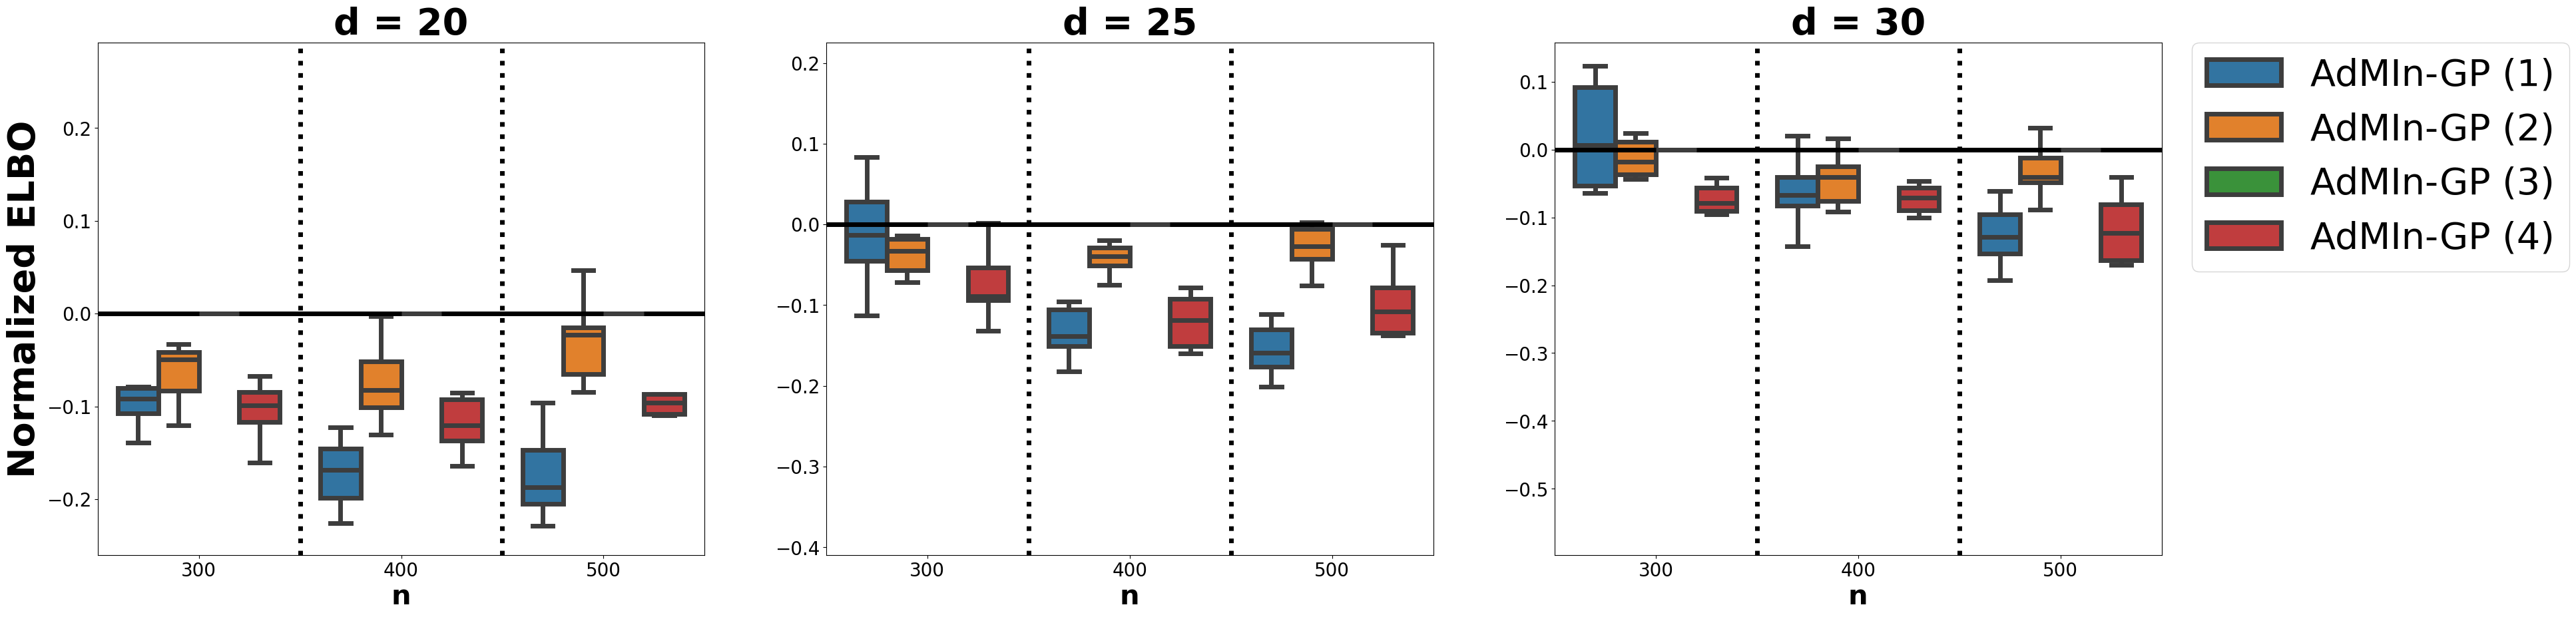

In [28]:
stat_replace = {'rmse': 'RMSE', 'crps': "CRPS", 'cov': "95% Coverage", "nll": "NLL", 'loss': "Normalized ELBO"}
g_frame['Statistic'] = g_frame['Statistic'].replace(stat_replace)
met_replace = {'gpy': "ARD-GP", 'vim': 'AdMIn-GP (1)', 'vim2': 'AdMIn-GP (2)','dle': 'DLE-GP', 'dpa': 'DPA-GP', 
              'vim3': "AdMIn-GP (3)", 'vim4': 'AdMIn-GP (4)'}
g_frame['Method'] = g_frame['Method'].replace(met_replace)
stat_list = ['RMSE', 'CRPS','95% Coverage', "Normalized ELBO"]

mix_frame = g_frame[g_frame['Method'].isin(["AdMIn-GP (1)", "AdMIn-GP (2)", "AdMIn-GP (3)", "AdMIn-GP (4)"])]

import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(1, 3, figsize = (40, 10))

for i in range(3):
    sns.boxplot(data = mix_frame[ np.logical_and(mix_frame["Statistic"] == 'Normalized ELBO', mix_frame['D'] == D_vec[i]) ],
            y = "Value", x = "n",  hue = "Method", 
               ax = axs[i], dodge= .25, fliersize= 0, linewidth=5, hue_order = ["AdMIn-GP (1)","AdMIn-GP (2)",  "AdMIn-GP (3)", "AdMIn-GP (4)"])
    
    axs[i].set_xlabel("n", fontweight = "bold", fontsize = 30)
    
    if i == 0:
        axs[i].set_ylabel("Normalized ELBO", fontweight = "bold", fontsize = 40)
    else:
        axs[i].set_ylabel(None)
    axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize = 40)
    axs[i].axhline(0, lw = 5, color = "black")
    if i != 2:
        axs[i].get_legend().remove()
    
    axs[i].set_title("d = {}".format(D_vec[i]), fontweight = "bold", fontsize = 40)
    [axs[i].axvline(x+.5,linestyle = ":", lw = 5, color = "black") for x in list(axs[i].get_xticks())[:-1]]
plt.savefig('paper_plots/sim_elbo.png', dpi = 200, bbox_inches='tight')
